# Lab assignment: SVMs in scikit-learn

In this assignment we will learn how to work with SVMs using the scikit-learn library. We will study in detail their cross-validation and pipelining.

## 0. Guidelines

<table align="center">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve a question. You should pay attention to these hints to better understand questions.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>

During the assignment you will make use of several Python packages that might not be installed in your machine. It is strongly recommended that you use the environment file *environment.yml* and follow the instructions of the following <a href="https://github.com/jorloplaz/teaching_material/tree/master/SVM">link</a>.

If you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells.

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells.

Let's go!

## Synthetic dataset

For the first exercises of this assignment we will use the synthetic dataset generated by the following code:

In [2]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
RND_STATE=np.random.RandomState(42)
# Build first cluster
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=RND_STATE)
# Build second cluster
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=RND_STATE)
# Fuse them, scaling features differently and switching labels of y2
X = np.concatenate((X1, X2))
X[:, 0] *= 10
X[:, 1] /= 10
y = np.concatenate((y1, -y2+1))

The dataset consists of 500 points and consists of two Gaussian clusters. In each cluster points in its inner circle belong to one class, and those in the outer circle belong to the other class. Classes are switched in the second cluster so that it is more challenging to discriminate between both classes.

If we plot these data we obtain the following:

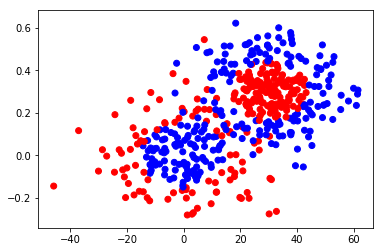

In [3]:
from matplotlib.colors import ListedColormap
cm = ListedColormap(['#0000FF', '#FF0000'])    # blue, red
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm)     
plt.show()

Once we have generated the data (X, y), let us split them into a **training set** and a **test set**. There is a utility function in scikit-learn that does exactly this:

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RND_STATE)

Since *test_size=0.5*, both the training set and the test set will have 250 points each. The number of features is 2, as specified when invoking *make_gaussian_quantiles*:

In [5]:
print(X_train.shape)
print(X_test.shape)

(250, 2)
(250, 2)


## Scikit-learn basics

Scikit-learn's models for **supervised learning** (SVMs are just one kind of such models) implement a common interface. The most important functions of this interface are the following:

* **fit(X, y)**: trains the model, fitting it for input patterns X and outputs y.
* **score(X, y)**: tests an already fitted model with additional data, returning the accuracy obtained (i.e., how similar the outputs given by the model are, compared to the true outputs y).

Thus, all classifiers and regressors in scikit-learn have specific implementations for the above functions. The differences among models (e.g., the different parameters they use) are treated either during construction or internally within these functions.

For the particular case of SVMs for classification, the implementing class is <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">SVC</a>:

In [6]:
from sklearn.svm import SVC
SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

As you can see, by default scikit-learn builds an SVM with the RBF kernel. We know that such an SVM needs 2 parameters: C (regularizer between model complexity and classification errors) and gamma (kernel width). These are set to 1 and to 'auto' respectively, where 'auto' stands for 1/d (that is, 1 divided by the number of features).

If you want to create an instance of an SVM with other values for these parameters, you just specify them (the rest of options for the constructor can be safely ignored for now):

In [7]:
SVC(C=5, gamma=0.01)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In practice it is difficult to know which values for C and gamma work best for a particular dataset. This is why it is common to try with a **grid** of values for both parameters, selecting the pair of values that result in the highest accuracy.

The first step is selecting the parameter **ranges**. For this exercise, let us use these:

In [11]:
Cs = np.logspace(-2, 4, 7)
gammas = np.logspace(-4, 4, 9)

That is, C ranges from 0.01 to 10000, whereas gamma goes from 0.0001 to 10000, using powers of 10 as intermediate values.

Recall that in order to avoid **overfitting**, we cannot use the test set for **tuning** these parameters. The following code keeps track of the accuracies obtained for the training set, selecting the best C and gamma:

In [12]:
# Accuracies
accs = np.zeros((len(Cs), len(gammas)))   # all accuracies (in matrix form)
best_acc = 0.0   # best accuracy
# For each C
for i, C in enumerate(Cs):
    # For each sigma
    for j, gamma in enumerate(gammas):
        # Create and train SVM
        svm = SVC(C=C, gamma=gamma).fit(X_train, y_train)
        # Keep track of accuracies and best params
        acc = svm.score(X_train, y_train)
        accs[i, j] = acc
        if acc > best_acc:
            best_C = C
            best_gamma = gamma
            best_acc = acc

It is illustrative to plot these accuracies in matrix form:

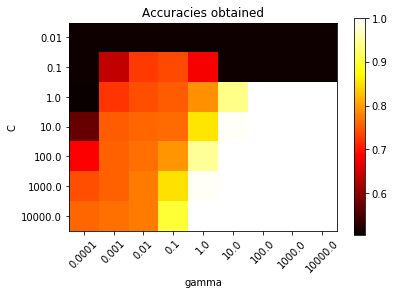

In [13]:
plt.imshow(accs, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Accuracies obtained')
plt.show()

The best parameters turn out to be:

In [14]:
print("Best C = " + str(best_C))
print("Best gamma = " + str(best_gamma))

Best C = 1.0
Best gamma = 100.0


Which give a perfect accuracy on the training set:

In [16]:
print("Best accuracy on train = " + str(best_acc))

Best accuracy on train = 1.0


## Cross-validation

Perfect accuracy may seem like great news. However, the performance on the test set is not so good:

In [17]:
best_model = SVC(C=best_C, gamma=best_gamma).fit(X_train, y_train)
best_model.score(X_test, y_test)

0.628

This is a clear sign of overfitting on the training set. If you remember from the theory, ideally we should tune our model fitting it with the training set, but assessing performance on a separate set called **validation set**.

However, usually there are not enough data to split them into separate training, validation and test sets. If that is the case, we can resort to **cross-validation**, which proceeds as follows:
* The training set is partitioned into k subsets (called **folds**).
* k different models are trained, using each of the k folds to assess performance and the remaining k-1 folds to fit each model.
* The best model is that whose average performance on the k folds is best.

Programming all this is laborious. Fortunately, the team behind scikit-learn have a whole <a href="http://scikit-learn.org/stable/modules/cross_validation.html">cross-validation module</a>. In addition, the library also has a class specifically designed to perform grid search on the parameters you specify, which is called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a>:

In [18]:
from sklearn.model_selection import GridSearchCV

As the documentation states, in order to build an instance of *GridSearchCV*, you will need to specify two objects:
* An **estimator**, that is, the internal model that is optimized (in this case an *SVC* instance).
* A **parameter grid**, a dictionary where you specify the parameter names and the ranges to perform the search on (these ranges were defined above).

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Use the code cell below to create a <i>GridSearchCV</i> object called <i>gs</i> with the SVM as estimator and the range for <i>C</i> and <i>gamma</i> we defined above.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

GridSearchCV is implemented as well as a model, so its fit(X, y) method is the one that performs the grid search, doing cross-validation under the hood.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Call the fit method on your <i>gs</i> object to perform the grid search on the training set. Do not worry if it takes some time to complete. 
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     If you build your <i>GridSearchCV</i> object above with <i>verbose=1</i> you will see a trace of how the cross-validation process is going. For more details, set <i>verbose=2</i>. If your PC has several processors you can speed up the whole process by setting <i>n_jobs</i> accordingly.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

Now that the grid search is complete, let us recover the results obtained. To keep things as before, we would like to overwrite the following variables:
* *accs*: accurary matrix for the different (C, gamma) pairs.
* *best_acc*: best accuracy.
* *best_C*: best value for C.
* *best_gamma*: best value for gamma.
* *best_model*: fitted model with the best C and the best gamma.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Recover these variables from the fitted <i>gs</i> object. Check the <i>attributes</i> section in the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">documentation</a>.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     You do not need to retrain <i>best_model</i> from <i>best_C</i> and <i>best_gamma</i>, it is available directly in the <i>best_estimator_</i> attribute (notice the final underscore). Think also about how to get the accuracies in matrix form from <i>cv_results_</i>. Numpy's <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html">reshape</a> function may come in handy.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Replot the accuracies just retrieved. In what way is the resulting figure different from the previous one?
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Reprint the best parameters and their accuracy on training. Explain the changes you observe.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Recalculate the accuracy on test. Dit it improve?
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

## Pipelining

So far we have assumed that, once the data are loaded, they are ready to be fed to our model without any changes. If you inspect the code above, there is no change in the dataset since creation till it is fed to the *fit(X, y)* method (note that splitting the patterns in validation folds does not change the patterns themselves).

In practice this will rarely be the case. The data usually need some kind of previous transformations, such as making them all be uniform. This is what is known as **preprocessing**. Combining these transformations with other processes like cross-validation is tricky, as one must make sure that the transformations take place in each of the validation folds, so that the models are only fitted with properly transformed data.

Once more, we are lucky that scikit-learn makes this task very easy. The class that encapsulates all this is called <a href=http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html>Pipeline</a>:

In [ ]:
from sklearn.pipeline import Pipeline

Conceptually, a pipeline is defined as a series of **transformers**, followed by one final step which must be an estimator. In the scikit-learn's jargon, this means that the class that takes the last step must implement the method *fit(X, y)*, whereas all the previous classes must implement a new method called *transform(X)* that makes some modification on the input data X. If those transformations are data-dependent and have to be learnt, they must also implement another method called *fit_transform(X, y)*.

Scikit-learn hides this complexity by implementing Pipeline itself as a model as well. Thus, this class complies with the interface we saw in the previous section: 
* **fit(X, y)**: calls *fit_transform(X, y)* for all transformers, then calls *fit(X, y)* for the final estimator. This means that all transformations are successively learnt and applied before fitting the model with the properly transformed data.
* **score(X, y)**: calls *transform(X)* for all transformers, then calls *score(X, y)* for the final estimator. The final model requires transformed data, and all the transformations have been learnt by *fit(X, y)*, so they can be now applied directly.

As the <a href="http://scikit-learn.org/stable/modules/pipeline.html">usage guide</a> describes, in order to build an instance of <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">Pipeline</a> you will need to specify a list of **steps**, that is, the transformers and the final estimator you wish to chain. For internal reference, each of these steps must be identified by a name as well as by its class, so the steps are passed as a list of (name, class) pairs. Consider the following example:

In [ ]:
Pipeline([('svm', SVC())])

Which builds a pipeline with just one estimator (the default SVM), named *svm*. 

Obviously, a pipeline makes sense only when there is more than a single step. To keep things simple, here we will add just one previous step before the SVM, which performs **normalization to zero mean and unit variance**. This is carried out by the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> class:

In [ ]:
from sklearn.preprocessing import StandardScaler

This normalization makes all features be in the same scale, preventing that some feature may have a bigger influence than others just because of the different original scales. If you go back to the dataset's plot, you can see that the scale of the first coordinate is much larger than the second one ([-40, +60] range compared to [-0.3, +0.6]). If we applied an RBF SVM to the data as they are, when computing the kernel function the second coordinate would be negligible compared to the first one. 

However, the figure makes clear that both features are equally important for correct classification, so normalization should improve accuracies considerably. Let us see if this is indeed the case.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Build a pipeline called <i>pl</i> with a <i>StandardScaler</i> followed by an SVM. Name both steps as you please.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

Performing grid search is trivial now, since *pl* is a valid estimator for the *GridSearchCV* object.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Rewrite the grid search for the pipeline. This should overwrite again the variables <i>accs</i>, <i>best_acc</i>, <i>best_C</i>, <i>best_gamma</i> and <i>best_model</i>.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Since the pipeline steps are named, the way to access parameters now is <i>step__parameter</i> (notice the double underscore). For example, in the pipeline above, we would access the <i>C</i> parameter with <i>svm__C</i>.
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Replot the new accuracies. Are they different from the ones without the scaler?
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Reprint the best parameters and their accuracy both on training and test. How did they change? Are they better now?
 </td></tr>
</table>

In [ ]:
####### INSERT YOUR CODE HERE

<center>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
                          THIS IS THE END OF THE ASSIGNMENT<br>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
</center>